Author: Michael Stoll\
6/7/2024\
\
The dataset I'm working with is the results of a questionaire filled out by over 500 people about their mental state; in particular, participants are evaluated on an integer scale from 0 (No struggle at all) to 5 (Constant struggling) about their ability to Sleep, their Appetite, their Interest in the world around them, their Fatigue, their own sense of Worthlessness, their difficulties with Concentration, their levels of Agitation, their prevalence of Suicidal thoughts, their amount of Sleep Disturbance, their levels of Aggression, the frequency of their Panic Attacks, their sense of Hopelessness, their sense of Restlessness, and their frequency of Low Energy.\
Then, their Depression state is evaluated by 4 potential options: No Depression, Mild, Moderate, and Severe. For the sake of processing, these will be translated into integers so that the Depression State column can be used as the target.\
\
Having established that, in this assignment I am going to evaluate this depression-stats dataset with 5 different algorithms to see which one best predicts the Depression State of a person based on the other data points (features) present.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('depression-stats.csv', sep=',')
data = data.dropna()
#for some reason, for two entries, there is a leading integer and tab character.
#they are both under "No depression", so I converted the replace statement to a regex to handle it.
#in addition, for some reason one of the values is 50 on a questionaire that is supposed to max at 3, so I'm making sure we never go that high.
#this is sort of like using a battleaxe to open a letter, but it does certainly get the job done.
data['Depression_State'] = data['Depression_State'].str.strip().replace('(0-9)*\t*No depression','0',regex=True)
data['Depression_State'] = data['Depression_State'].str.strip().replace('Mild','1')
data['Depression_State'] = data['Depression_State'].str.strip().replace('Moderate','2')
data['Depression_State'] = data['Depression_State'].str.strip().replace('Severe','3')
data['Depression_State'] = data['Depression_State'].astype(float)
data = data.drop(data[data['Depression_State'] > 3.1].index)

Just for illustrative purposes, I'm going to show the correlation of these data points, so that I can have a rough idea for the efficiency I should be looking for as I try to predict the depression state.

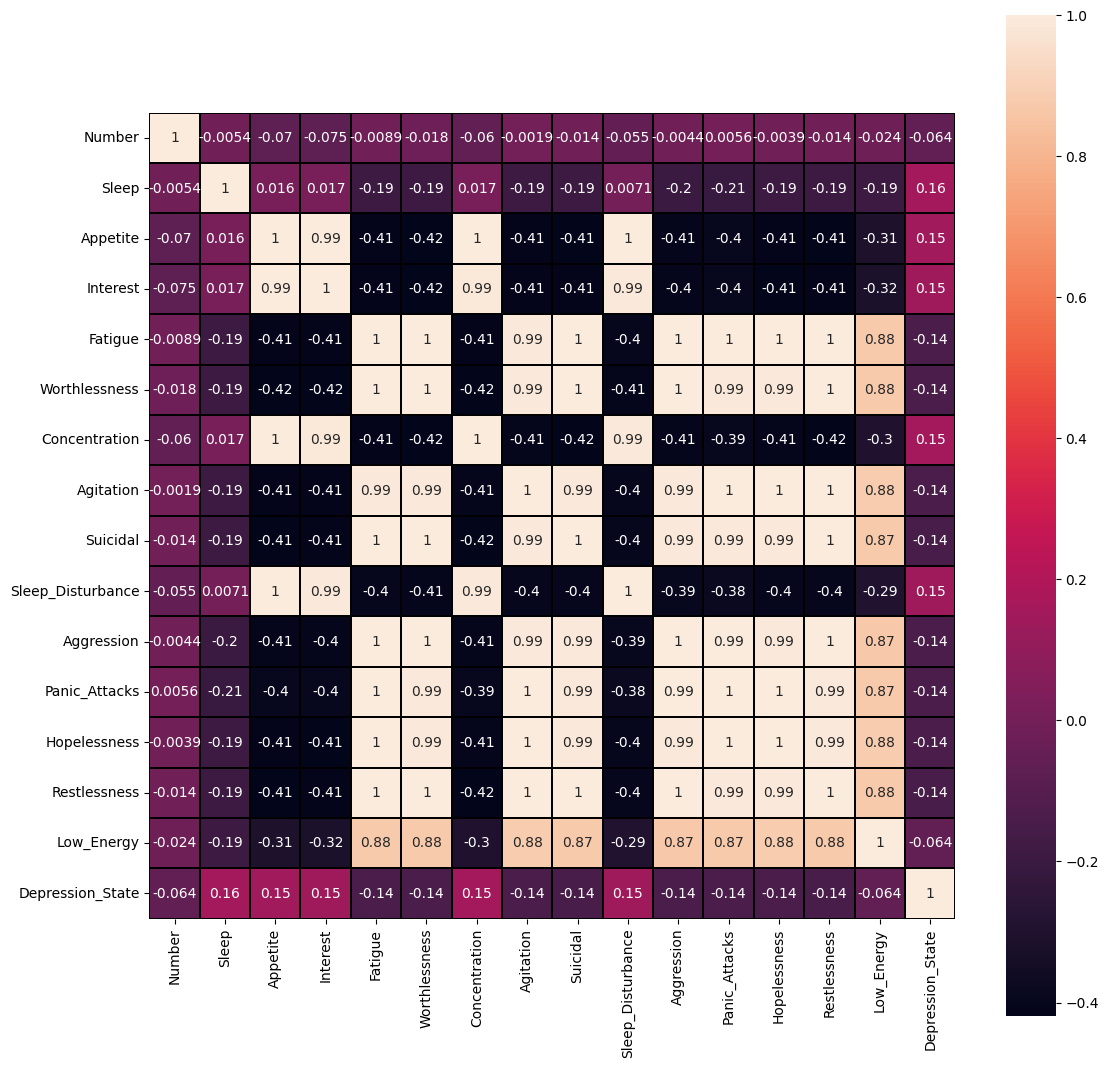

In [2]:
df = pd.DataFrame(data)
plt.figure(figsize=(13,13))
sns.heatmap(df.corr(), square = True, annot=True, annot_kws={'fontsize':10}, linewidths=.1, vmax=1, linecolor='black')#, cmap='Grays')
plt.show()

Notably, there are several cases in which there is a very strong, and sometimes even perfect, correlation between two features. One such example is the perfect alignment between Fatigue and Worthlessness.\
\
Also notable is how little the depression state correlates to anything else, comparatively. My hypothesis is that this has happened for a number of reasons: first, a sample size of 538 is not very large at all, and it's possible (and, dare I say, likely) that this is not a truly random sample of people given the nature of the distribution of these sorts of questionaires; second, working on an integer scale makes things rather black and white, and for a more accurate representation of the real world there really ought to be more room for a grey area between 1 and 2 (perhaps it would be worth it to create an analog slider instead of a multiple choice form?); and finally, unreliability in self-scoring. By this I mean I hypothesize that people answered lower on their depression state than they should have. This could be for myriad reasons, such as the stigma surrounding the label of depression or simply being unable to see the forest for the trees (accurately calling out Fatigue or Aggression, but being unable to see what the factors add up to), or it could simply not be at all. Without access to the original participants for additional testing, I will never be able to do more than hypothesize, so I am going to approach this data as neutrally as possible while being aware that that is a potential complication.\
\
Regardless, I'm sticking to my guns and continuing to choose Depression State to be my target. I figure if I'm going to go through the trouble to choose the "best" algorithm, I may as well make each one of them run the gauntlet against data that isn't clean and perfect to see which one of them best handles it. I'm sure my accuracies would be much higher if I were to run Hopelessness or something but this is simply more realistic.\
\
\
Here, I'm just going to break the data into the requisite pieces for testing. I want a test size of ~20% of what I have, since I'd normally go higher but with less than 600 entries I want to make sure that I have as much to train on as possible.

In [3]:
from sklearn.model_selection import train_test_split
features = data.drop(columns=['Depression_State'])
target = data['Depression_State']
feature_train, feature_test, target_train, target_test = train_test_split(features, target, test_size=.20, random_state=72)

First up on the list is the random forest algorithm. The idea behind this is that, in this specific case, 75 different decision trees will be put together and evaluated against the data. 75 is an arbitrary number, but I'm finding that there is a sort of asymptote related to the number of estimators. For some reason, after you pass about 75 estimators on my machine you end up with roughly the same accuracy. For whatever reason, the more decision trees that exist, the lower the final accuracy. My hypothesis is that this is a combinatronics problem, in that when more decision trees exist there has to be more agreement and therefore lower overall accuracy since it's harder to fulifll agreement between 75 trees than, say, 3.

Accuracy(%): 33.33333333333333


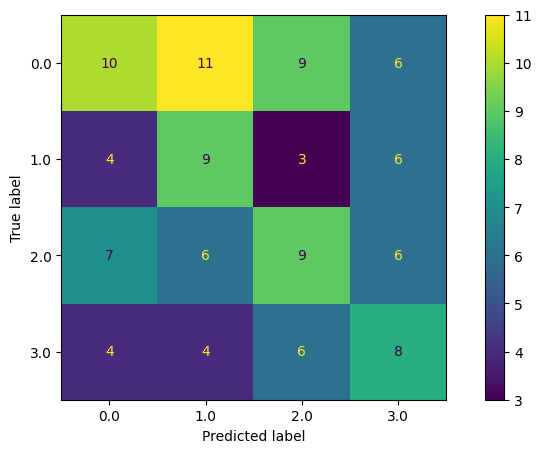

In [4]:
#random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
rf = RandomForestClassifier(n_estimators=75, random_state=420)
rf.fit(feature_train, target_train)
rfPred = rf.predict(feature_test)
rfAcc = accuracy_score(target_test, rfPred) * 100
print("Accuracy(%): " + str(rfAcc))

fig, ax = plt.subplots(figsize=(10,5))
ConfusionMatrixDisplay.from_predictions(target_test, rfPred, ax=ax)

The heatmap shows roughly what the accuracy suggests, in that the highest values tend to be along the correct diagonal, but we still end up with over 60% of the data in the false negative/false positive portions of the heatmap. Importantly, the randomized forest predicted that far more of the people polled would answer that they were depressed than the number that actually did. This could fall into my hypothesis of underperformance, or it could be a symptom of an issue with this specific algorithm. The only way to know is to run another.\
\
Next on the list is the support vector machine. Without delving too deep into specifics, the idea behind this one is that it uses the data gathered to most accurately draw the line between two classifications of data in such a way that the classifications are evenly split. My hypothesis is that this will yield a poorer result than the last one, since the data that I'm working with is numerical instead of categorical.

Accuracy(%): 40.74074074074074


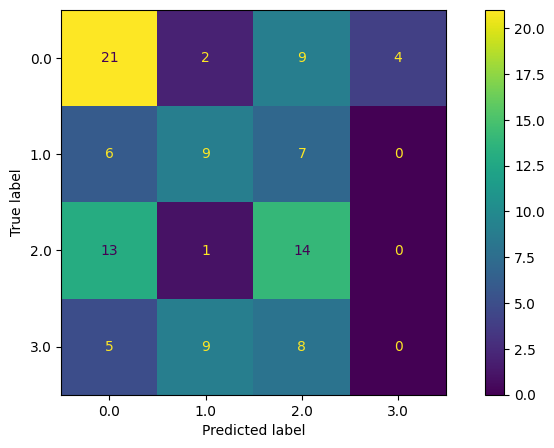

In [5]:
#support vector machine
from sklearn.svm import SVC
svm = SVC(kernel='linear', gamma=.5, C=1)
svm.fit(feature_train, target_train)
svmPred = svm.predict(feature_test)
svmAcc = accuracy_score(target_test, svmPred) * 100
print("Accuracy(%): " + str(svmAcc))

fig, ax = plt.subplots(figsize=(10,5))
ConfusionMatrixDisplay.from_predictions(target_test, svmPred, ax=ax)

There are some contradictions in the data laid before us. The accuracy claims that this is a better algorithm than the random forest, but the heatmap shows that this is because there are simply stronger predictions for the values 0 and 2 than there are in the random forest. Given details such as there being exactly 0 people that were correctly mapped to be a level 3 Depression state in this one vs the 8 in the previous algorithm, I would actually argue that the random forest is a stronger algorithm than the support vector machine, but I suppose I can't really argue with the accuracy when it's simply a projection of the data that is correctly predicted. I digress.\
\
Next up is a good old-fashioned linear regression: an algorithm that creates a function that is mapped to match given data so that it can be used to predict the result of future unknown inputs. For the sake of being able to directly compare this algorithm with the others, I've chosen to round the predicted values to the nearest integer so that the data could be represented in a heatmap. To demonstrate the effect of this change, I'm going to show a scatterplot of the raw data, and then a scatterplot of the rounded data.\
These scatterplots require one specific feature to be singled out and compared, I've chosen the data column "Suicidal" because I believe that that is one of the strongest correlative features to Depression State.

Text(0, 0.5, 'Depression Score')

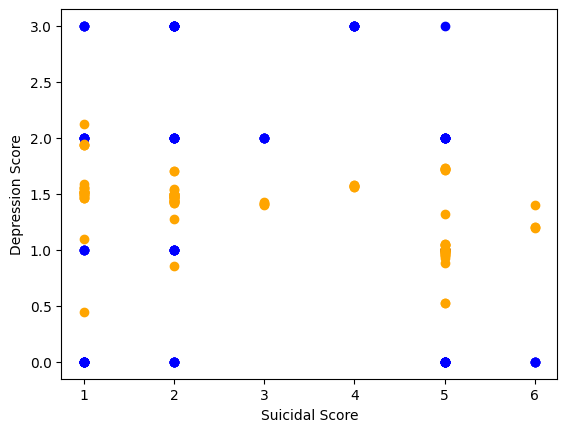

In [12]:
#linear regression
import sklearn.linear_model
lreg = sklearn.linear_model.LinearRegression()
lreg.fit(feature_train, target_train)
lregPred = lreg.predict(feature_test)

sd = feature_test['Suicidal']
plt.scatter(sd, target_test, color='blue')
plt.scatter(sd, lregPred, color='orange')
plt.xticks()
plt.xlabel('Suicidal Score')
plt.yticks()
plt.ylabel('Depression Score')

Clearly, this scatterplot shows strong groups of correlation along the vertical axes. Notably, before the data is processed, the data falls almost entirely between ~.7 and 2.0.\
Now it's time to process the data and see what happens.

Accuracy(%): 15.74074074074074


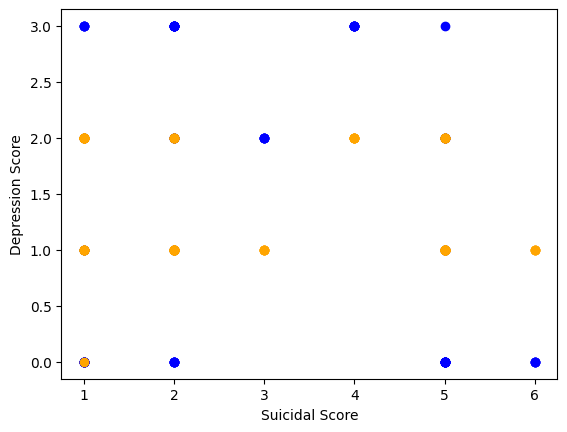

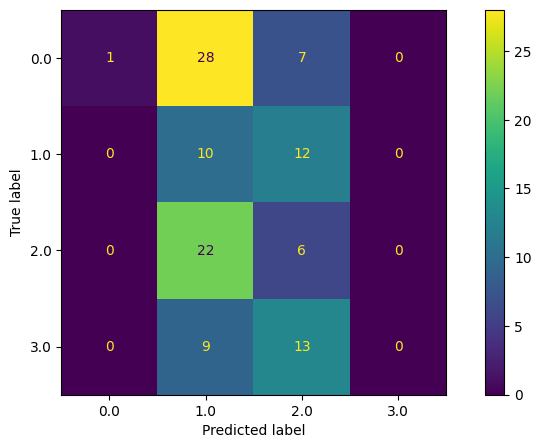

In [14]:
lregRound = np.rint(lregPred)
sd = feature_test['Suicidal']
plt.scatter(sd, target_test, color='blue')
plt.scatter(sd, lregRound, color='orange')
plt.xticks()
plt.xlabel('Suicidal Score')
plt.yticks()
plt.ylabel('Depression Score')

lregAcc = accuracy_score(target_test, lregRound) * 100
print("Accuracy(%): " + str(lregAcc))

fig, ax = plt.subplots(figsize=(10,5))
ConfusionMatrixDisplay.from_predictions(target_test, lregRound, ax=ax)

The scatterplot shows that the data was processed exactly as desired; every value has been rounded to the nearest integer. Based off of what we've already surmised from the two scatterplots, unsurprisingly, the spread of this heatmap was predicted to fall almost entirely between 1 and 2. Notably, not a single person was predicted to have a Depression State of 3, and only 1 was predicted to have a level of 0. If there wasn't a data type mismatch and we could directly build a heatmap with the "raw" data the actual accuracy would probably be a few percentage points higher, but not enough to change the location of the linear regression in the rankings. So, the linear regression takes last place thus far.\
\
Now we move onto the decision tree learner. In essence, the decision tree is a simpler version of the random forest algorithm (which would explain tree vs forest). Basically, the decision tree approach is just the random forest algorithm if there was only 1 tree from which to build a model.

Accuracy(%): 29.629629629629626


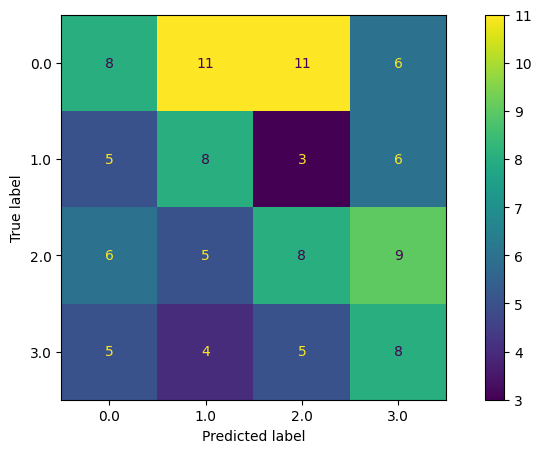

In [7]:
#decision tree learner
from sklearn.tree import DecisionTreeRegressor
rt = DecisionTreeRegressor()
rt.fit(feature_train, target_train)
rtPred = rt.predict(feature_test)
rtAcc = accuracy_score(target_test, rtPred) * 100
print("Accuracy(%): " + str(rtAcc))

fig, ax = plt.subplots(figsize=(10,5))
ConfusionMatrixDisplay.from_predictions(target_test, rtPred, ax=ax)

Though this is a slightly better representation (in my opinion) of the heatmap, it's clear by the accurancy and the heatmap together that the trend of the data still diverges into false negative/false positive territory too strongly for this algorithm to be strongly considered to be the "best" choice. Simplicity of input begats simplicity of output, and in this case that simplicity is a detriment instead of a benefit. Therefore, it's now time to move on.\
\
Last up is gradient boosting. This one works on the idea that you can put many things that learn a little together and end up with one thing that has learned a lot. For this experiment, I've chosen 50 estimators to learn 5% of the data each, so that when combined they hopefully have far more than the requisite amount of data and so can accurately predict what should come next with the advent of more data.

Accuracy(%): 41.66666666666667


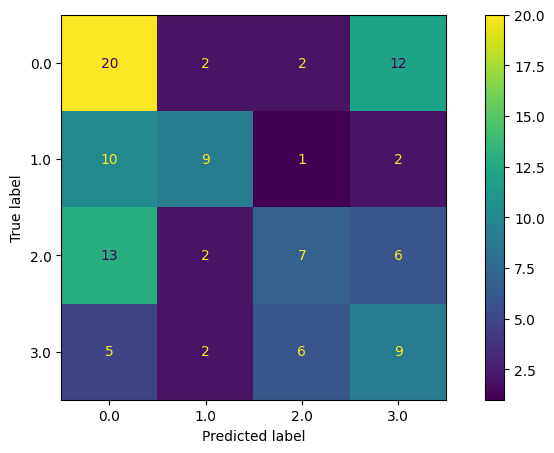

In [8]:
#gradient boosting
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators=50, learning_rate=.05, random_state= 301,
                                max_features=13)
gb.fit(feature_train, target_train)
gbPred = gb.predict(feature_test)
gbAcc = accuracy_score(target_test, gbPred) * 100
print("Accuracy(%): " + str(gbAcc))

fig, ax = plt.subplots(figsize=(10,5))
ConfusionMatrixDisplay.from_predictions(target_test, gbPred, ax=ax)

As is clear in the heatmap, this algorithm somwhat combines the best of both worlds, in that there is a (somewhat) strong correlation across the main diagonal, and that additionally, the data that does diverge from correct prediction tends to stay pretty close to the correct value.\
A notable exception to this statement is the large amount of data points predicted to have a Depression State of 0 that actually fell strongly across a Depression State of 1, 2, and 3. This appears to directly contradict my earlier hypothesis that the Depression State data is skewed by self-identification error instead of some other systemic error, so I now (tentatively) concede that argument and lean further towards believing that this is likely an issue of a small data size since this is the strongest algorithm of the bunch. I say "tentatively" because this is an outlier, and the rest of the algorithms appear to be either neutral or leaning towards error in self-identification, so I'd want to see more data before committing fully to any position.\
\
Obviously, we haven't come across a model that does much better than the one above, but I don't think that was ever really the point. As previously mentioned, the data already had a weak correlation before any of these tests started, and my goal was simply to find the best algorithm, not to make any of them better.\
\
However, I believe that this gradient boosting algorithm is the strongest of the above listed algorithms. Despite the anomalous nature of the predicted 0's, the strong heatmap and accurancy in predicting the Depression State of a participant means that this is that "best" algorithm I was looking for (in terms of this specific dataset, at least).